### Deep Hedging


Payoff to hedge: $Z$

Wealth process with transaction cost:
$$
V_T = V_0 + (H\cdot S)_T - C_T.
$$
Given $V_0$, find the best strategy $H$ that minimize
$$
\mathbb{E}[\ell ((P-V_T)_+)]
$$
where $P$ is the payoff and $\ell(x) = \frac{x^{p}}{p},\quad p > 0$.

We numerically minimize the loss consisting of three terms
\begin{equation}
    \mathcal{L}(K) = \mathcal{L}_{p}(K) + \mathcal{L}_{\text{cost}}(K) + \mathcal{L}_{\text{ad}}(K),
\end{equation}
where 
\begin{equation*}
\begin{aligned}
    \mathcal{L}_{p}(K) &= \mathbb{E}\Big[\ell ((P-V_T)_+) \Big],\\
    \mathcal{L}_{\text{cost}}(K) &= c_{\text{cost}}\mathbb{E}\Big[\sum_{t=1}^{T-1}\lvert H_{t+1} - H_{t}\rvert \cdot S_{t}\Big],\\
    \mathcal{L}_{\text{ad}}(K) &= c_{\text{ad}}\mathbb{E}\Big[(-\min_{t}V_{t})_{+}\Big],
\end{aligned}
\end{equation*}

In [1]:
import numpy as np
import torch

from math import ceil
import matplotlib.pyplot as plt

from neuralhedge.nn import datahedger, contigent, mlp, loss
from neuralhedge.nn.loss import ExpectedShortfall
from neuralhedge.market import stochastic
from neuralhedge._utils.plotting import plot_pnl, plot_history, plot_data_set, plot_hedge
from importlib import reload


Shape of paths:  torch.Size([50000, 31, 1])
Shape of information:  torch.Size([50000, 31, 2])
Shape of payoff:  torch.Size([50000, 31, 1])


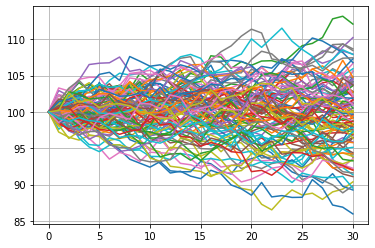

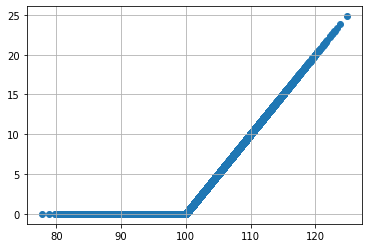

True price is:  tensor(2.3095)


In [2]:
n_paths = 50000
step_size = 1/365
maturity = 30/365
n_steps = ceil(maturity / step_size)
initial_value = 100.
strike = initial_value
mu = 0.0
sigma = 0.2

blackscholes = stochastic.BlackScholes(mu = mu, 
                            sigma = sigma,
                            n_paths = n_paths,
                            n_steps = n_steps,
                            step_size = step_size)
blackscholes.stimulate(initial_value = initial_value)
option = contigent.EuropeanVanilla(strike = strike)

paths = blackscholes.prices     # (n_paths, n_steps+1, n_asset)

information = torch.cat([
    torch.log(blackscholes.prices),
    blackscholes.times_inverse
    ], axis = -1)
    
payoff = option.payoff(blackscholes.prices)   # (n_paths, n_steps+1, 1)

n_asset = paths.shape[-1]
n_feature = information.shape[-1]
data_set = [paths, information, payoff]
plot_data_set(data_set)
dataset_market = datahedger.MarketDataset(data_set)

print('True price is: ', payoff[:,-1].mean())

Loss=0.28740429878234863: 100%|██████████| 30/30 [00:50<00:00,  1.67s/it]


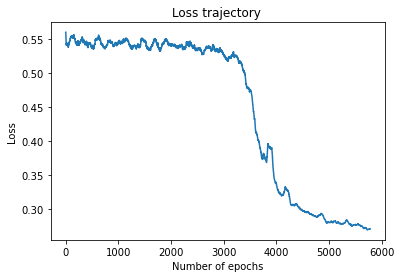

In [8]:
from typing import List
from typing import Optional

from torch import Tensor
from torch.nn import Module

price = 2.0
class EfficientHedger(datahedger.Hedger):
    def __init__(self,model: Optional[Module]):
        super().__init__(model)
    def compute_pnl(self, input: List[Tensor]):
        prices, information, payoff = input
        wealth= self(input)
        pnl = wealth - payoff + price
        return pnl


model = mlp.NeuralNetSequential(n_output = n_asset)

hedger = datahedger.Hedger(model) 
history = hedger.fit(dataset_market, EPOCHS=30,criterion=loss.PowerMeasure(10)) 

plot_history(history)

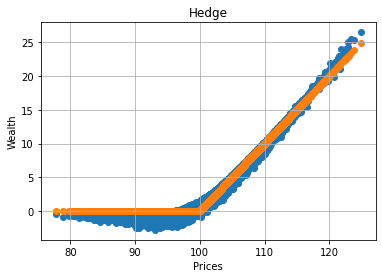

Price:  2.0


In [9]:
paths,_,payoff = data_set
wealth0 = hedger(data_set).detach().numpy()
wealth = wealth0 + price


plt.figure
plt.scatter(paths[:,-1,0], wealth[:,-1,0])
plt.scatter(paths[:,-1,0], payoff[:,-1,0])
plt.title("Hedge")
plt.xlabel("Prices")
plt.ylabel("Wealth")
plt.grid()
plt.show()

print('Price: ', price)